<a href="https://colab.research.google.com/github/xbadiam/Marketing_Campaign/blob/main/notebooks/MarketingCampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Campaña de marketing
Aumentar las ganancias de una campaña de marketing

### Contexto

Un modelo de respuesta puede aumentar significativamente la eficiencia de una campaña de marketing, ya sea incrementando las respuestas o reduciendo los gastos. El objetivo es predecir quién responderá a una oferta de un producto o servicio.

In [1]:
!rm -rf /content/Marketing_Campaign

! git clone https://github.com/xbadiam/Marketing_Campaign.git

Cloning into 'Marketing_Campaign'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 128 (delta 50), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 3.64 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn import metrics
from google.colab import files

# Modelado
# ==============================================================================
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


## 3. Funciones auxiliares


In [23]:
def plot_elbow_rule(datasets, min_k: int = 1, max_k: int = 10) -> None:
    """Computes and shows SSE for each value of k in k-means.

    This is a generic solution that receives a list containing datasets,
    and shows a plot for each datset.

    Args:
        datasets: list
            A list of np.array with shape (points, dimensions).
        min_k: int
            The lowest value of k to try.
        max_k: int
            The highest value of k to try.
    """
    fig, ax = plt.subplots(1, len(datasets), figsize=(8, 4))
    for i, a in zip(range(len(datasets)), ax if type(ax) == np.ndarray else (ax,)): # Fixed: ensure ax is iterable for single dataset case
        x = range(min_k, max_k + 1)
        y = []
        X = datasets[i]
        for nc in x:
            kmeans = KMeans(n_clusters=nc, n_init=10, random_state=42)
            dists = kmeans.fit_transform(X)
            y.append(np.sum(np.min(dists, axis=1) ** 2))
        a.plot(x, y, marker='o')
        a.set_xlabel('k (# de clusters)')
        a.set_ylabel('SSE')
        a.set_title('Dataset {}'.format(i))
        a.set_xticks(range(min_k, max_k + 1))
        a.grid()
    plt.tight_layout()


def silhouette_Coefficient(data, min_k: int = 2, max_k: int = 12) -> None:
  """
  Calcula el silhouette score para un rango de valores k y grafica los resultados.
  El dataset debe ser el conjunto de características (por ejemplo, PCA).
  """
  # Copia para no modificar el DataFrame original
  dataset = data.copy()

  # Eliminamos columna 'Clusters' si existe
  if 'Clusters' in dataset.columns:
    dataset = dataset.drop(columns=['Clusters'])

  sil_scores = {}

  for k in range(min_k, max_k + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(dataset)

    sample_size = min(10000, len(dataset))

    sil = metrics.silhouette_score(dataset, labels, sample_size=sample_size)
    sil_scores[k] = sil
    print(f"k={k} -> silhouette={sil:.4f}")

  best_k_by_sil = max(sil_scores, key=sil_scores.get)
  print("Mejor k por silhouette:", best_k_by_sil)

  # Gráfico
  plt.plot(range(min_k, max_k + 1), list(sil_scores.values()), marker='o')
  plt.xlabel('Número de clusters (k)')
  plt.ylabel('Puntuación Silhouette')
  plt.title('Análisis Silhouette para determinar k óptimo')
  plt.grid(True)
  plt.show()


def evaluate_ks(X, ks=range(2,13)):
  results = {}
  for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    n_labels = len(set(labels))
    if n_labels < 2:
      continue
    sample_size = min(10000, len(X))
    sil = metrics.silhouette_score(X, labels, sample_size=sample_size)
    ch = metrics.calinski_harabasz_score(X, labels)
    db = metrics.davies_bouldin_score(X, labels)
    results[k] = {'silhouette': sil, 'ch': ch, 'db': db}
    print(f"k={k}: silhouette={sil:.4f}, CH={ch:.1f}, DB={db:.4f}")
  return pd.DataFrame(results).T

## 4. Cargar datos

In [5]:
data = pd.read_csv('/content/Marketing_Campaign/outputs/output.csv')
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,0,1,68,1617,0,Single,0
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,0,71,27,1,Single,2
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,0,60,776,0,Partner,0
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,0,41,53,1,Partner,1
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,0,44,422,1,Partner,1


In [6]:
print("Número de características:", len(data.columns))
print("Longitud del conjunto de datos:", len(data))

Número de características: 30
Longitud del conjunto de datos: 2234


In [7]:
# Visualizamos los tipos de cada uno de los atributos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2234 non-null   object 
 1   Marital_Status       2234 non-null   object 
 2   Income               2234 non-null   float64
 3   Kidhome              2234 non-null   object 
 4   Teenhome             2234 non-null   object 
 5   Dt_Customer          2234 non-null   object 
 6   Recency              2234 non-null   int64  
 7   MntWines             2234 non-null   int64  
 8   MntFruits            2234 non-null   int64  
 9   MntMeatProducts      2234 non-null   int64  
 10  MntFishProducts      2234 non-null   int64  
 11  MntSweetProducts     2234 non-null   int64  
 12  MntGoldProds         2234 non-null   int64  
 13  NumDealsPurchases    2234 non-null   int64  
 14  NumWebPurchases      2234 non-null   int64  
 15  NumCatalogPurchases  2234 non-null   i

## 5. Preprocesado

In [8]:
# Selección de las columnas numéricas y categóricas
# ==============================================================================

numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

In [9]:
# Preprocesamiento
# ==============================================================================

preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='drop') # no queremos columnas sin procesar

## 6. Reducción de dimensionalidad (PCA)

In [10]:
# Dimensionalidad resultante
# ==============================================================================

# Primero transformamos para ver dimensionalidad resultante
X_preprocessed = preprocessor.fit_transform(data)
feature_names = preprocessor.get_feature_names_out()

print("Número de features tras preproc:", X_preprocessed.shape[1])

Número de features tras preproc: 701


Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos explained_variance_ y explained_variance_ratio_ del modelo.

In [11]:
# PCA
# ==============================================================================

# PCA reteniendo 95% varianza (svd_solver='full' ya que usamos ratio)
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

print("Componentes retenidas por PCA:", pca.n_components_)
print("Varianza acumulada total:", np.sum(pca.explained_variance_ratio_))


Componentes retenidas por PCA: 27
Varianza acumulada total: 0.9527168749034798


Si se empleasen 27 componentes se conseguiría explicar el 95% de la varianza observada.

In [18]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')

print(np.round(pca.explained_variance_ratio_, 4))  # 4 decimales para claridad

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.2924 0.083  0.0684 0.0506 0.0388 0.0366 0.0357 0.0335 0.0301 0.0283
 0.0271 0.0243 0.022  0.0215 0.0207 0.0174 0.0164 0.0158 0.0142 0.0133
 0.0123 0.0108 0.0106 0.0088 0.0078 0.0066 0.0058]


In [13]:
#  DataFrame PCA
# ==============================================================================

PCA_dataset = pd.DataFrame(X_pca,
                           columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                           index=data.index)

In [15]:
PCA_dataset.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,4.501882,-0.094988,-0.399081,2.056418,-0.256917,-0.221209,0.015546,-1.046802,-1.262022,2.124300,...,-1.439778,-0.108954,0.482702,0.002421,-0.587348,0.531140,0.554337,-0.289004,0.016047,-0.445268
1,-2.776196,0.128743,-0.157356,-0.791478,-1.296969,0.398762,-0.388052,0.881388,0.288314,0.915418,...,-0.380063,-0.388299,0.277346,-0.024403,-0.105992,-0.324650,0.116184,-0.306694,0.080446,-0.271599
2,2.143981,-0.734468,-1.100111,-0.283863,-0.549582,-0.903958,0.631328,-1.273107,0.394224,-0.092504,...,0.318452,0.241567,1.318295,0.996963,0.768314,-0.319237,0.016871,-0.554958,0.544586,-0.202886
3,-2.661001,-1.235059,0.130223,0.347337,0.473181,-0.709644,0.736625,0.472579,0.447377,-0.560747,...,-0.070799,-0.030699,0.536811,0.053357,0.966135,0.094521,0.345388,-0.126326,-0.332050,0.180783
4,-0.573153,0.416378,-0.796664,0.141727,1.820311,0.187651,-0.128987,0.591444,-0.563548,-0.696121,...,0.653563,0.247474,-0.498892,0.894659,-0.496684,-0.306686,0.563770,-0.286592,0.059799,0.662936


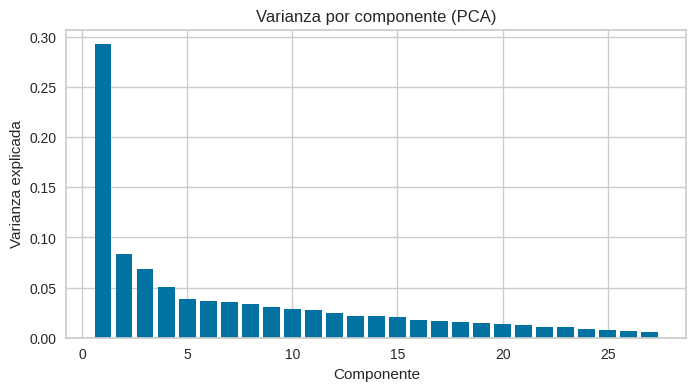

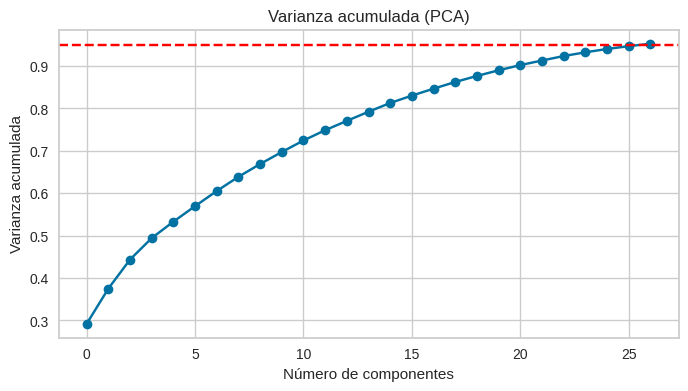

In [17]:
#  Visual: varianza por componente y acumulada
# ==============================================================================

plt.figure(figsize=(8,4))
plt.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_)
plt.xlabel('Componente')
plt.ylabel('Varianza explicada')
plt.title('Varianza por componente (PCA)')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada (PCA)')
plt.show()


En este caso, la primera componente explica el 29% de la varianza observada en los datos y la segunda el 8%. Las dos últimas componentes no superan por separado el 1% de varianza explicada.

## 7. Determinar k: Elbow + Silhouette + Calinski-Harabasz + Davies-Bouldin

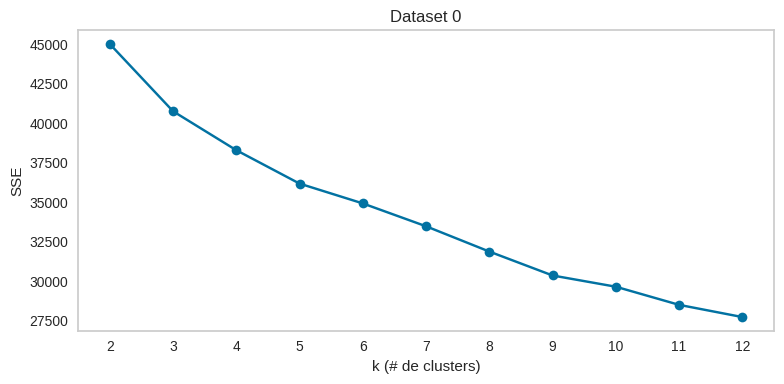

In [26]:
#  Visual: Elbow
# ==============================================================================

plot_elbow_rule([PCA_dataset], min_k=2, max_k=12)

k=2 -> silhouette=0.2743
k=3 -> silhouette=0.1913
k=4 -> silhouette=0.1911
k=5 -> silhouette=0.1993
k=6 -> silhouette=0.1665
k=7 -> silhouette=0.1201
k=8 -> silhouette=0.1205
k=9 -> silhouette=0.1190
k=10 -> silhouette=0.1209
k=11 -> silhouette=0.1229
k=12 -> silhouette=0.1261
Mejor k por silhouette: 2


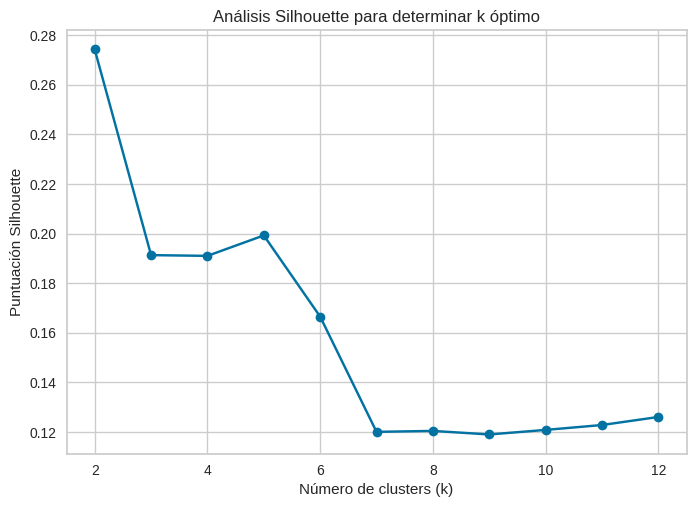

In [58]:
silhouette_Coefficient(PCA_dataset)

La grafica muestra que el numero óptimo de cluesters son 2, por lo que se procedera a entrenar un modelo Kmeans el cual permita clasificar los datos.

In [24]:

eval_df = evaluate_ks(PCA_dataset, ks=range(2,13))
display(eval_df)

k=2: silhouette=0.2743, CH=696.9, DB=1.6825
k=3: silhouette=0.1913, CH=501.2, DB=2.0340
k=4: silhouette=0.1911, CH=403.3, DB=2.0919
k=5: silhouette=0.1993, CH=352.6, DB=1.8104
k=6: silhouette=0.1665, CH=310.0, DB=1.5659
k=7: silhouette=0.1201, CH=283.7, DB=1.9333
k=8: silhouette=0.1205, CH=275.1, DB=1.8272
k=9: silhouette=0.1190, CH=262.9, DB=1.8853
k=10: silhouette=0.1209, CH=250.3, DB=1.8617
k=11: silhouette=0.1229, CH=238.4, DB=1.8278
k=12: silhouette=0.1261, CH=228.3, DB=1.8442


,silhouette,ch,db
2,0.274258,696.933714,1.682481
3,0.191345,501.185247,2.034044
4,0.191051,403.341428,2.091908
5,0.199292,352.594551,1.810380
6,0.166550,309.958557,1.565945
7,0.120101,283.744673,1.933260
8,0.120482,275.098336,1.827204
9,0.119045,262.947984,1.885256
10,0.120885,250.256158,1.861703
11,0.122859,238.363002,1.827842


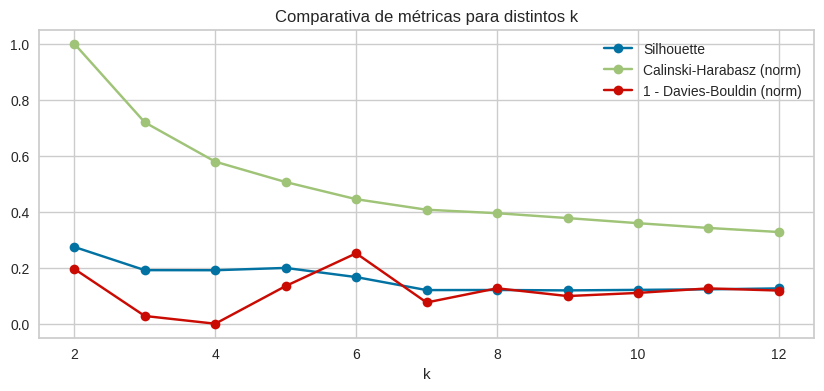

In [25]:
#  Visual comparativo
# ==============================================================================

# Visual comparativo
plt.figure(figsize=(10,4))
plt.plot(eval_df.index, eval_df['silhouette'], marker='o', label='Silhouette')
plt.plot(eval_df.index, eval_df['ch']/eval_df['ch'].max(), marker='o', label='Calinski-Harabasz (norm)')
plt.plot(eval_df.index, 1 - (eval_df['db']/eval_df['db'].max()), marker='o', label='1 - Davies-Bouldin (norm)')
plt.xlabel('k')
plt.legend()
plt.title('Comparativa de métricas para distintos k')
plt.grid(True)
plt.show()

In [57]:
#  Selección k (mejor por silhouette)
# ==============================================================================

best_k = eval_df['silhouette'].idxmax()
print("Mejor k por silhouette:", best_k)

Mejor k por silhouette: 2


## 8. Modelado: Clustering con Kmeans

En este apartado probamos el algorismo k-means sobre el dataset obtenido anteriorment, ajustando los parámetros adecuados, y analizando sus resultados.

Se utilizará el metodo Elbow para definir el número de clusters

In [48]:
kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init=50)
labels = kmeans.fit_predict(PCA_dataset)

In [49]:
# Añadir labels a PCA_dataset y al dataset original (sin alterar original)
PCA_dataset['Clusters'] = labels
data_clusters = data.copy()
data_clusters['Clusters'] = labels

In [65]:
data_clusters.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children,Clusters
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,1,68,1617,0,Single,0,1
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,71,27,1,Single,2,0
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,60,776,0,Partner,0,1
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,41,53,1,Partner,1,0
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,44,422,1,Partner,1,0


In [50]:
print(Counter(labels))

Counter({np.int32(0): 1323, np.int32(1): 911})


## 9. Evaluación del modelo

In [51]:
# Eliminar columna que informa los clusters
X_for_eval = PCA_dataset.drop(columns=['Clusters'])

# Aplicamos la evaluación
sil_final = metrics.silhouette_score(X_for_eval, labels)
ch_final = metrics.calinski_harabasz_score(X_for_eval, labels)
db_final = metrics.davies_bouldin_score(X_for_eval, labels)

print(f"Final metrics -> Silhouette: {sil_final:.4f}, CH: {ch_final:.1f}, DB: {db_final:.4f}")

Final metrics -> Silhouette: 0.2619, CH: 690.6, DB: 1.6921


## 10. Perfilado: medias y tamaños por cluster

In [52]:
profile_num = data_clusters.groupby('Clusters')[numeric_cols].mean().round(3)
counts = data_clusters['Clusters'].value_counts().sort_index()
profile_summary = profile_num.copy()
profile_summary['size'] = counts
display(profile_summary)

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Children,size
Clusters,,,,,,,,,,,,,,,,,,,,,
0,38928.044,48.784,98.741,6.360,36.013,9.163,6.333,21.958,2.531,2.912,...,0.000,0.005,0.002,0.010,0.094,54.875,178.568,0.899,1.263,1323
1,70861.134,49.591,602.288,55.071,356.866,78.372,57.203,75.618,2.029,5.797,...,0.177,0.149,0.031,0.008,0.228,57.898,1225.418,0.450,0.499,911


## 11. Heatmap de medias por cluster

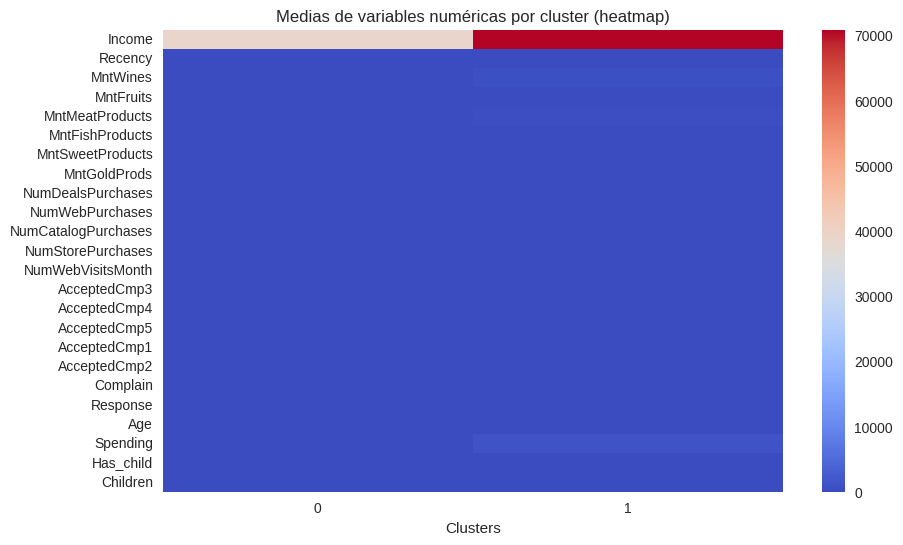

In [53]:
plt.figure(figsize=(10,6))
sns.heatmap(profile_num.T, cmap='coolwarm', annot=False)
plt.title('Medias de variables numéricas por cluster (heatmap)')
plt.show()

## 12. PCA 2D con clusters

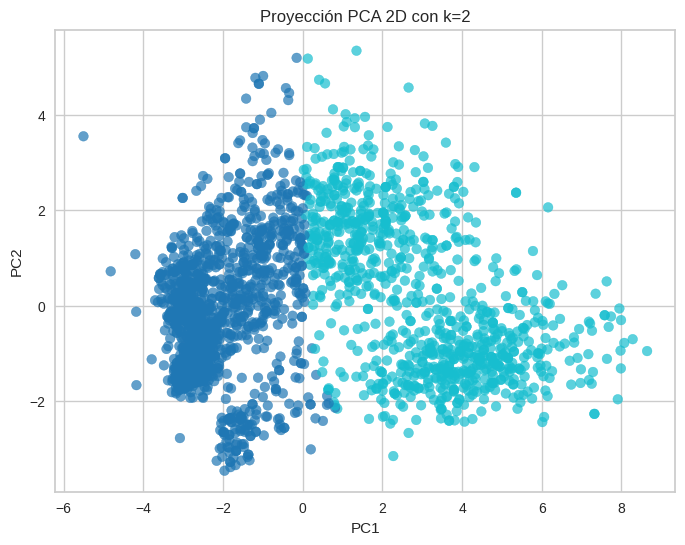

In [54]:
# proyectar usando las primeras 2 PCs
X_pca_2d = PCA_dataset.iloc[:, :2].values
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Proyección PCA 2D con k={best_k}')
plt.grid(True)
plt.show()

## 13. Conclusiones

Tras el preprocesado y reducción de dimensionalidad (PCA) se retuvieron 27 componentes que explican el 95% de la varianza.

El análisis de validación multi-métrica (Elbow, Silhouette, Calinski–Harabasz, Davies–Bouldin) sugiere k = 2, es decir, un cluster de 2.

El modelo K-Means con k=2 genera 2 clusters con tamaños: 1323 (60 %) y de 911 40 %. Perfilando cada segmento (medias de variables clave) observamos patrones accionables:

* Segmento A: (edad media, ingreso, gasto, propensión a responder) — recomendable campaña X.

** Segmento B: ... (Sustituir A/B/C por los clusters reales e incluir bullets con acciones: campañas diferenciadas, prioridades, estimación de ROI)

## 14. Guardado de pipelines y modelo

In [55]:
import joblib

joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(pca, 'pca.joblib')
joblib.dump(kmeans, 'kmeans.joblib')


['kmeans.joblib']

## 15. Export: perfil por cluster a **csv**

In [56]:
profile_summary.to_csv('cluster_profile_summary.csv', index=True)
files.download('cluster_profile_summary.csv')